A pipeline for processing single-cell RNA-seq data for bladder cancer

This pipeline is based on dataset [GSE146137](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE146137).


# Preprocessing

In [2]:
import os
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import doubletdetection
from scipy.stats import median_abs_deviation as mad
%matplotlib inline

data_path = "data/"
check_path = "checkpoints/"
table_path = "tables/"
fig_path = "figures/"

In [4]:
os.chdir("../")
!pwd

/Users/flynnzhang/CMU/Spring24/02620-ML4Scientists/scRNA-seq_ML


In [5]:
import warnings
warnings.simplefilter("ignore", FutureWarning)
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", RuntimeWarning)

In [8]:
files = os.listdir('data/')
mouse_files = sorted([f for f in files if 'mouse' in f])
mf_pref = sorted([''.join(f.split('_MCL_10X_mouse_raw_counts')).replace('.txt', '') for f in mouse_files])

mf_pref, mouse_files

(['GSM4367145_4950N',
  'GSM4367146_4950P',
  'GSM4367147_8524N',
  'GSM4367148_8524P',
  'GSM4367149_8525N',
  'GSM4367150_8525P'],
 ['GSM4367145_MCL_10X_mouse_raw_counts_4950N.txt',
  'GSM4367146_MCL_10X_mouse_raw_counts_4950P.txt',
  'GSM4367147_MCL_10X_mouse_raw_counts_8524N.txt',
  'GSM4367148_MCL_10X_mouse_raw_counts_8524P.txt',
  'GSM4367149_MCL_10X_mouse_raw_counts_8525N.txt',
  'GSM4367150_MCL_10X_mouse_raw_counts_8525P.txt'])

In [10]:
!mkdir data/h5ad

mkdir: data/h5ad: File exists


In [12]:
# make anndata of bladder cancer from ".txt" files
for i, f in enumerate(mf_pref):
    adata = sc.read(data_path + mouse_files[i], delimiter="\t").T
    adata.write_h5ad(data_path + 'h5ad/' + f + ".h5ad")

### QC

In [8]:
adatas = sorted([x for x in os.listdir(data_path + 'h5ad/')])

adatas

['GSM4367145_4950N.h5ad',
 'GSM4367146_4950P.h5ad',
 'GSM4367147_8524N.h5ad',
 'GSM4367148_8524P.h5ad',
 'GSM4367149_8525N.h5ad',
 'GSM4367150_8525P.h5ad']

In [9]:
def load_ann(f_name):
    samp = f_name.split('_')[0]
    title = f_name.split('_')[1].replace('.h5ad', '')
    marker = 'Positive'
    if 'N' in f_name.split('_')[1]:
        marker = 'Negative'
    
    
    adata = sc.read_h5ad(data_path + 'h5ad/' + f_name)
    adata.obs['Sample'] = samp
    adata.obs['Title'] = title
    adata.obs['Marker'] = marker
    return adata

In [10]:
adatas = [load_ann(f_name) for f_name in adatas]

adatas

[AnnData object with n_obs × n_vars = 2939 × 27998
     obs: 'Sample', 'Title', 'Marker',
 AnnData object with n_obs × n_vars = 1307 × 27998
     obs: 'Sample', 'Title', 'Marker',
 AnnData object with n_obs × n_vars = 6119 × 27998
     obs: 'Sample', 'Title', 'Marker',
 AnnData object with n_obs × n_vars = 2736 × 27998
     obs: 'Sample', 'Title', 'Marker',
 AnnData object with n_obs × n_vars = 5068 × 27998
     obs: 'Sample', 'Title', 'Marker',
 AnnData object with n_obs × n_vars = 7564 × 27998
     obs: 'Sample', 'Title', 'Marker']

In [11]:
def qc(adata):
    sc.pp.filter_cells(adata, min_genes = 200)
    
    adata.var["mt"] = adata.var_names.str.startswith("MT-")
    adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
    adata.var["hb"] = adata.var_names.str.contains(("^HB[^(P)]"))
    sc.pp.calculate_qc_metrics(adata, qc_vars=["mt", "ribo", "hb"], inplace=True, percent_top=[20], log1p=True)

    remove = ['total_counts_mt', 'log1p_total_counts_mt', 'total_counts_ribo', 
          'log1p_total_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb']
    
    adata.obs = adata.obs[[x for x in adata.obs.columns if x not in remove]]
    
    return adata

In [12]:
adatas = [qc(ad) for ad in adatas]

In [13]:
shapes = [ad.shape for ad in adatas]

shapes

[(2939, 27998),
 (1307, 27998),
 (6119, 27998),
 (2736, 27998),
 (5068, 27998),
 (7564, 27998)]

In [14]:
# merge obs tables
df = pd.concat([x.obs for x in adatas])
df = df.sort_values('Sample')

df

,Sample,Title,Marker,n_genes,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_20_genes,pct_counts_mt,pct_counts_ribo,pct_counts_hb
4950N_AAACCTGAGTTAAGTG,GSM4367145,4950N,Negative,4056,4056,8.308199,14489.0,9.581214,13.803575,0.0,0.0,0.0
4950N_GGACATTGTGTCGCTG,GSM4367145,4950N,Negative,2130,2130,7.664347,7257.0,8.889859,19.663773,0.0,0.0,0.0
4950N_GGACATTTCACGGTTA,GSM4367145,4950N,Negative,2582,2582,7.856707,17476.0,9.768641,31.437400,0.0,0.0,0.0
4950N_GGACATTTCCTGCAGG,GSM4367145,4950N,Negative,1521,1521,7.327781,4837.0,8.484257,28.219971,0.0,0.0,0.0
4950N_GGACATTTCGCATGGC,GSM4367145,4950N,Negative,2351,2351,7.763021,8701.0,9.071308,19.239168,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
8525P_CCCAACTCACATATCG,GSM4367150,8525P,Positive,3524,3524,8.167636,14753.0,9.599270,19.257100,0.0,0.0,0.0
8525P_CCCAACTAGGGATCAC,GSM4367150,8525P,Positive,2205,2205,7.698936,9214.0,9.128588,22.400695,0.0,0.0,0.0
8525P_CCCAACTAGACTAAGT,GSM4367150,8525P,Positive,2189,2189,7.691657,5572.0,8.625689,16.618808,0.0,0.0,0.0
8525P_CCCATTGAGTAGGCCA,GSM4367150,8525P,Positive,1010,1010,6.918695,1941.0,7.571474,26.429675,0.0,0.0,0.0


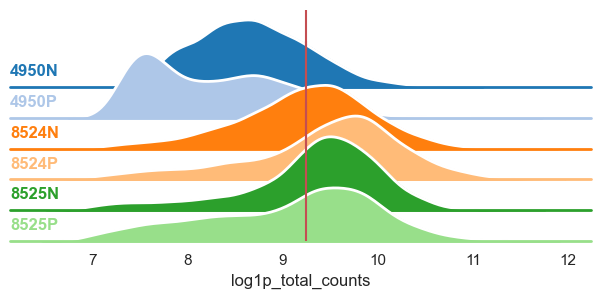

In [15]:
# value = "pct_counts_mt"
# value = "n_genes"
# value = 'pct_counts_in_top_20_genes'
value = "log1p_total_counts"

sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

g = sns.FacetGrid(df, row="Title", hue="Title", aspect=15, height=0.5, palette="tab20")

g.map(sns.kdeplot, value, clip_on=False, fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, value, clip_on=False, color="w", lw=2)

g.map(plt.axhline, y=0, lw=2, clip_on=False)

def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)

g.map(label, value)

g.figure.subplots_adjust(hspace=-.6)

g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)

for ax in g.axes.flat:
    ax.axvline(x=df[value].median(), color='r', linestyle='-')

plt.show()

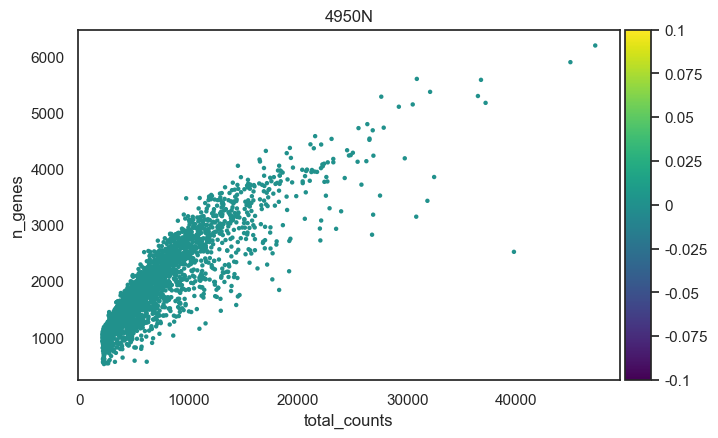

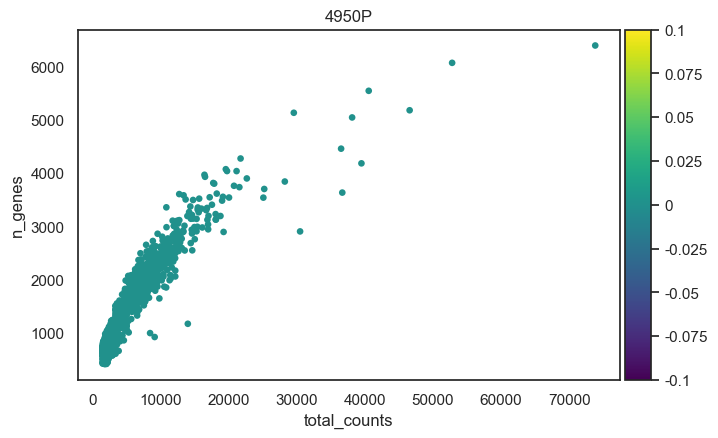

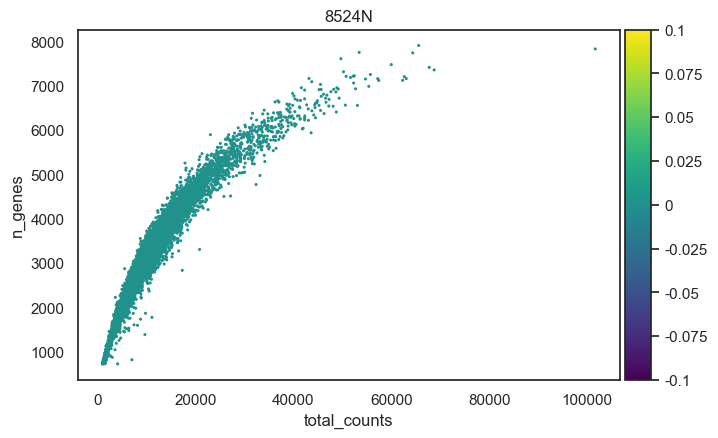

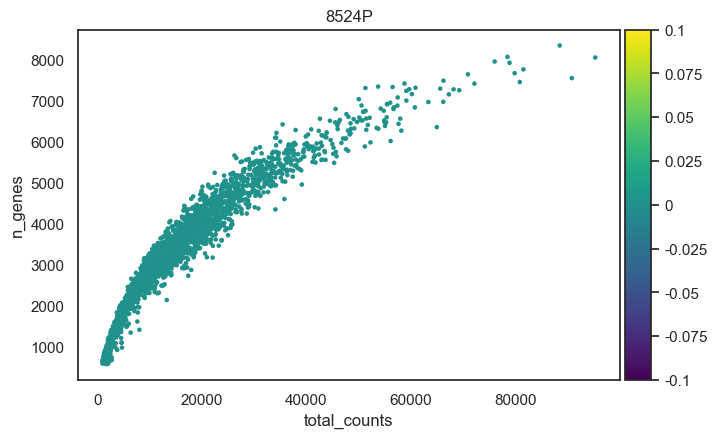

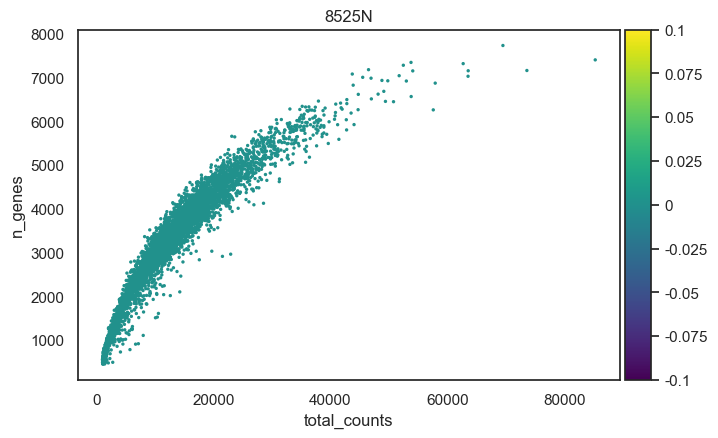

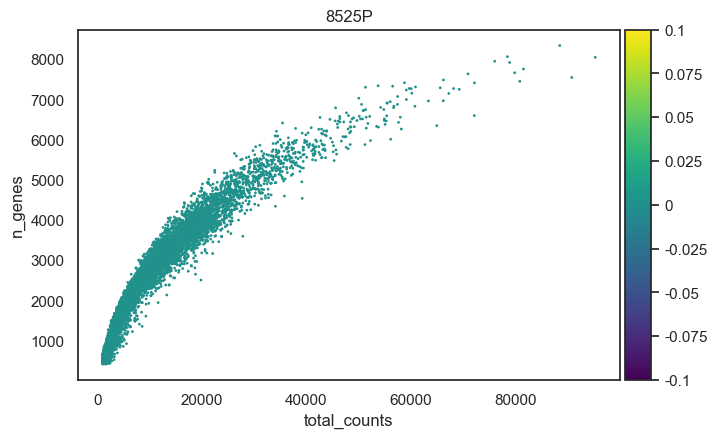

In [16]:
# plot scatter
for ad in adatas:
    sc.pl.scatter(ad, x='total_counts', y='n_genes', color='pct_counts_mt', title=ad.obs['Title'][0], show=False, color_map='viridis')
plt.show()

In [17]:
# write to file
for ad in adatas:
    ad.write_h5ad(data_path + 'clean/' + ad.obs['Sample'][0] + "_" + ad.obs['Title'][0] + ".h5ad")

### Remove doublets??

In [6]:
# outlier detection
def mad_outlier(adata, metric, nmads, upper_only = False):
    M = adata.obs[metric]
    
    if not upper_only:
        return (M < np.median(M) - nmads * mad(M)) | (M > np.median(M) + nmads * mad(M))
    
    return (M > np.median(M) + nmads * mad(M))

# import scvi

# pre-processing
def pp(f_path):
    adata = sc.read_h5ad(data_path + 'clean/' + f_path)
    
    adata = adata[adata.obs.pct_counts_mt < 25]
    bool_vector = mad_outlier(adata, 'log1p_total_counts', 5) +\
            mad_outlier(adata, 'log1p_n_genes_by_counts', 5) +\
            mad_outlier(adata, 'pct_counts_in_top_20_genes', 5) +\
            mad_outlier(adata, 'pct_counts_mt', 3, upper_only = True)
    adata = adata[~bool_vector]

    adata.uns['cells_removed'] = sum(bool_vector)

    return adata

In [7]:
adatas = sorted([f for f in os.listdir(data_path + 'clean/')])

adatas = [pp(ad) for ad in adatas]

In [8]:
adatas

[AnnData object with n_obs × n_vars = 2457 × 27998
     obs: 'Sample', 'Title', 'Marker', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_mt', 'pct_counts_ribo', 'pct_counts_hb'
     var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
     uns: 'cells_removed',
 AnnData object with n_obs × n_vars = 1188 × 27998
     obs: 'Sample', 'Title', 'Marker', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_mt', 'pct_counts_ribo', 'pct_counts_hb'
     var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
     uns: 'cells_removed',
 AnnData object with n_obs × n_vars = 5982 × 27998
     obs: 'Sample', 'Title', 'Marker', 'n_genes', 'n_genes_

# Integration

In [11]:
# merge all data
adata = sc.concat(adatas)
sc.pp.filter_genes(adata, min_cells = 5)

adata

AnnData object with n_obs × n_vars = 23873 × 19724
    obs: 'Sample', 'Title', 'Marker', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_mt', 'pct_counts_ribo', 'pct_counts_hb'
    var: 'n_cells'

In [12]:
from scipy.sparse import csr_matrix
# Convert the dense matrix to a sparse matrix to save memory
adata.X = csr_matrix(adata.X)

adata.write_h5ad(check_path + 'combined.h5ad')

In [20]:
adata.obs.groupby('Title').count()

,Sample,Marker,n_genes,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_20_genes,pct_counts_mt,pct_counts_ribo,pct_counts_hb
Title,,,,,,,,,,,
4950N,2457,2457,2457,2457,2457,2457,2457,2457,2457,2457,2457
4950P,1188,1188,1188,1188,1188,1188,1188,1188,1188,1188,1188
8524N,5982,5982,5982,5982,5982,5982,5982,5982,5982,5982,5982
8524P,2589,2589,2589,2589,2589,2589,2589,2589,2589,2589,2589
8525N,4647,4647,4647,4647,4647,4647,4647,4647,4647,4647,4647
8525P,7010,7010,7010,7010,7010,7010,7010,7010,7010,7010,7010


In [21]:
# samples coming from the same mouse should be coming from the same batch
adata.obs['batch'] = [batch[:-1] for batch in adata.obs['Title']]
# store the raw counts in a new layer in the adata object
adata.layers['counts'] = adata.X.copy()
# normalize the data and save it in the "raw" slot
sc.pp.normalize_total(adata, target_sum = 1e4)
sc.pp.log1p(adata)
adata.raw = adata

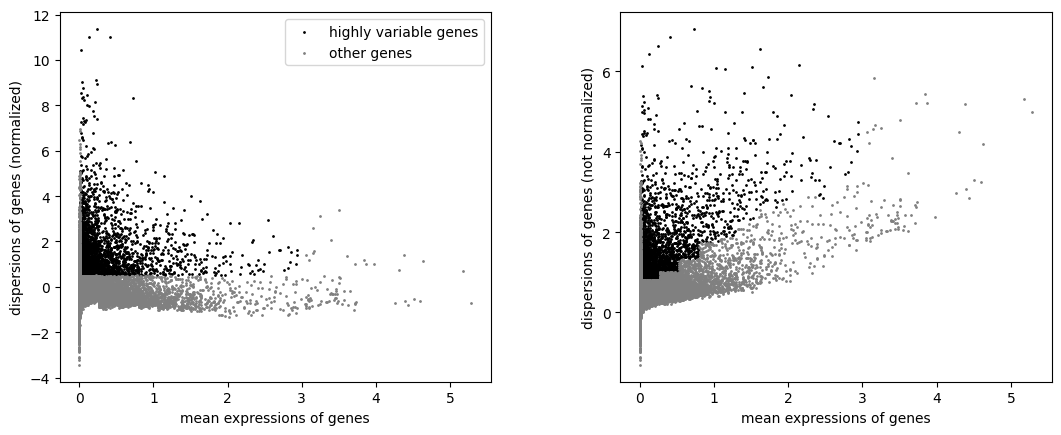

In [22]:
# get the highly variable genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata)

In [23]:
# subset the data to only include the highly variable genes
adata = adata[:, adata.var.highly_variable]

In [24]:
# regress out unwanted sources of variation
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])
# scale each gene to unit variance, clip values exceeding SD 10
sc.pp.scale(adata, max_value=10)

In [25]:
# write the normalized and scaled data to a new h5ad file
adata.write_h5ad(check_path + 'normalized.h5ad')

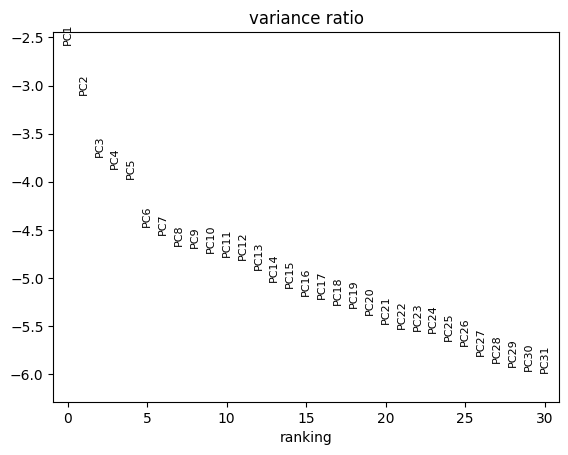

In [26]:
# perform PCA first
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata, log=True)

In [27]:
adata

AnnData object with n_obs × n_vars = 23873 × 2723
    obs: 'Sample', 'Title', 'Marker', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_mt', 'pct_counts_ribo', 'pct_counts_hb', 'batch'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'counts'

In [28]:
# write the PCA data to a new h5ad file
adata.write_h5ad(check_path + 'pca.h5ad')

In [30]:
import scanpy.external as sce
# harmony integration for batch correction
sce.pp.harmony_integrate(adata, key='batch')

2024-04-21 07:04:56,588 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-04-21 07:05:01,485 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-04-21 07:05:01,579 - harmonypy - INFO - Iteration 1 of 10
2024-04-21 07:05:05,893 - harmonypy - INFO - Iteration 2 of 10
2024-04-21 07:05:09,911 - harmonypy - INFO - Iteration 3 of 10
2024-04-21 07:05:14,169 - harmonypy - INFO - Iteration 4 of 10
2024-04-21 07:05:18,103 - harmonypy - INFO - Iteration 5 of 10
2024-04-21 07:05:22,436 - harmonypy - INFO - Converged after 5 iterations


In [31]:
adata.write_h5ad(check_path + 'harmony.h5ad')

In [40]:
# check if the batch correction worked
sc.pp.neighbors(adata, use_rep='X_pca_harmony')
sc.tl.umap(adata)

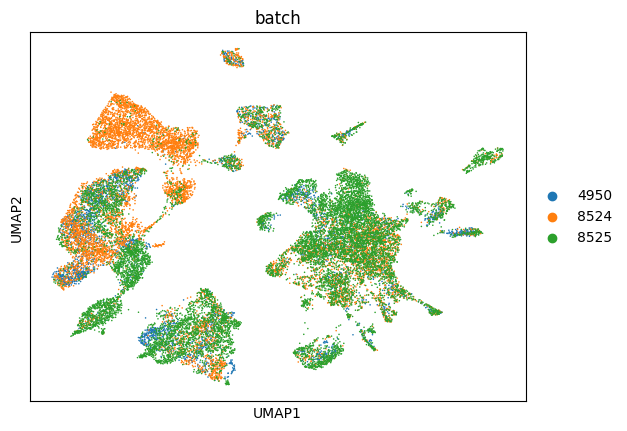

In [41]:
sc.pl.umap(adata, color='batch') # works

# Clustering

In [42]:
import gc
gc.collect()

25943

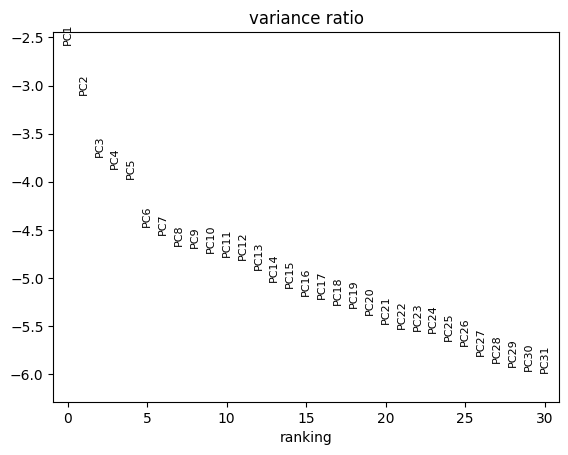

In [43]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata, log=True)

In [44]:
# neighborhood graph of cells (determine optimal number of PCs here)
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=30)
# compute UMAP
sc.tl.umap(adata)

In [48]:
# calc leiden clusters
sc.tl.leiden(adata, resolution = 0.2)

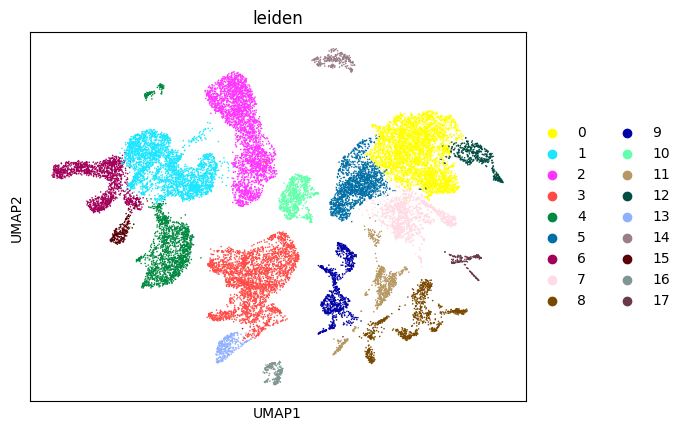

In [49]:
sc.pl.umap(adata, color=['leiden'])

In [ ]:
adata.write_h5ad(check_path + 'clustered_leiden.h5ad')